# Imports

In [109]:
import os
import time
import datetime
from pathlib import Path

import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

In [2]:
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [95]:
BASE_PATH = Path.home() / 'Uni/FIT2082/thermal2rgb/'

# Dataset

In [97]:
PATH = BASE_PATH / 'data/tufts_face_rgb_ir_stitched'

sample_image = tf.io.read_file(str(PATH / 'train/1-TD-A-0.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(128, 256, 3)


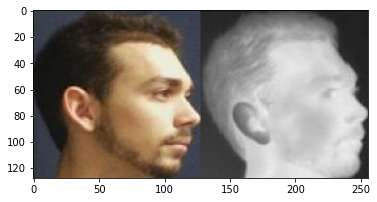

In [4]:
plt.figure()
plt.imshow(sample_image)
plt.show()

In [5]:
def load(image_file, height=256, width=256):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


    return input_image, real_image

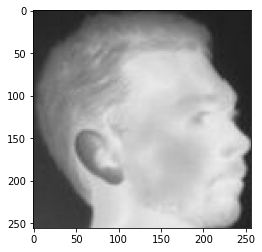

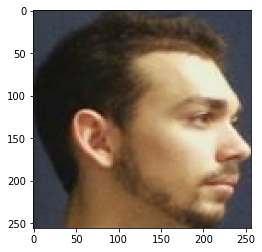

In [6]:
inp, re = load(str(PATH / 'train/1-TD-A-0.jpg'))

plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)
plt.show()

## Augmentation (jittering, mirroring)

In [7]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

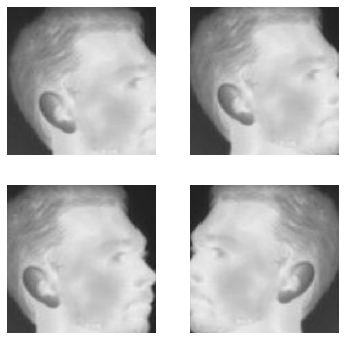

In [9]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [10]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Input pipeline

In [11]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [12]:
test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Generator

In [13]:
OUTPUT_CHANNELS = 3

In [14]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters,size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [15]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False)
    )
    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [17]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [18]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (batch_size, 128, 128, 64)
        downsample(128, 4), # (batch_size, 64, 64, 128)
        downsample(256, 4), # (batch_size, 32, 32, 256)
        downsample(512, 4), # (batch_size, 16, 16, 512)
        downsample(512, 4), # (batch_size, 8, 8, 512)
        downsample(512, 4), # (batch_size, 4, 4, 512)
        downsample(512, 4), # (batch_size, 2, 2, 512)
        downsample(512, 4), # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (batch_size, 8, 8, 1024)
        upsample(512, 4), # (batch_size, 16, 16, 1024)
        upsample(256, 4), # (batch_size, 32, 32, 512)
        upsample(128, 4), # (batch_size, 64, 64, 256)
        upsample(64, 4), # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 256, 256, 3)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

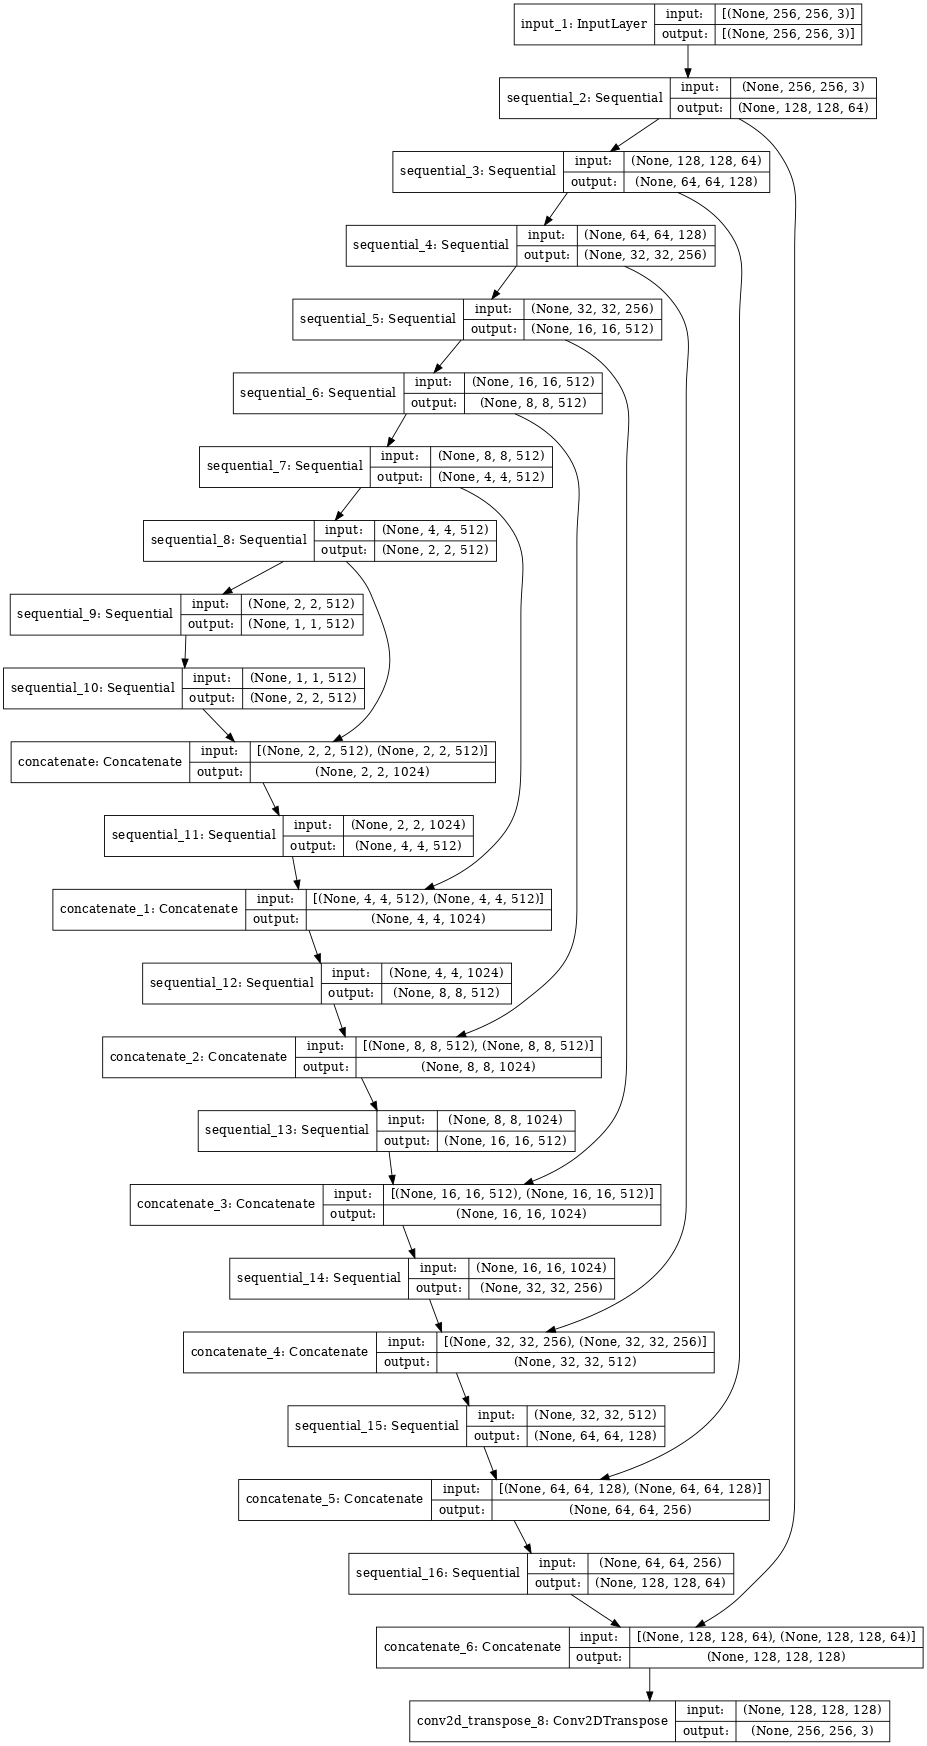

In [19]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


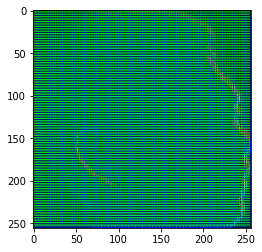

In [20]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Generator loss

In [21]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# Discriminator

In [22]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [23]:
def mlp_block(x, hidden_units):
    mlp_x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    mlp_x = mlp(mlp_x, hidden_units, dropout_rate=0.1)
    
    mlp_out = tf.keras.layers.Add()([mlp_x, x])

    return mlp_out

In [24]:
def attn_block(x, n_heads, key_dim):
    attn_x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    attn_x = tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, dropout=0.1)(attn_x, attn_x)
    
    attn_out = tf.keras.layers.Add()([attn_x, x])

    return attn_out

In [25]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.Concatenate()([inp, tar]) # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)

    out = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)
    
    # transformer module
    for _ in range(1):
        out = attn_block(out, n_heads=8, key_dim=128)
        out = mlp_block(out, hidden_units=[256, 128])
        
#     # join
#     conc = tf.keras.layers.Concatenate()([trans_out, base_out])
#     out = tf.keras.layers.Dense(1)(conc)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=out)

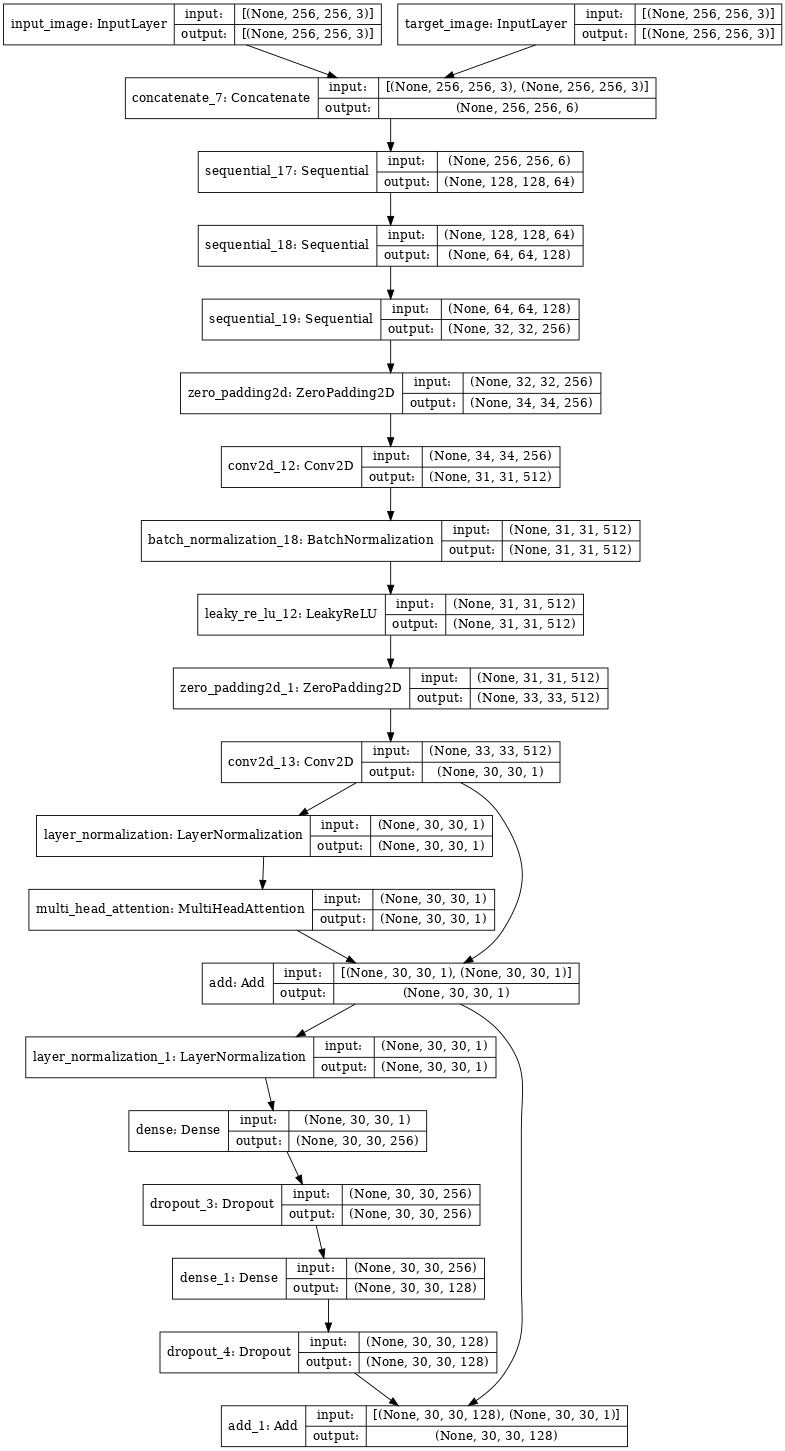

In [26]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

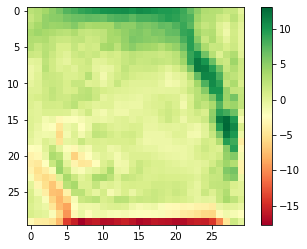

In [27]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], cmap='RdYlGn')
plt.colorbar()

## Discriminator loss

In [28]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Other utils (optimizers, checkpoint saver)

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [121]:
CHECKPOINT_DIR = Path('./training_checkpoints')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Plot generation

In [144]:
def generate_images(model, test_input, tar):
    gen_out = model(test_input, training=False) # training=True
    disc_out = discriminator([test_input, gen_out], training=False)
    
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], gen_out[0], disc_out[0, ..., -1]]
    title = ['Input Image', 'Ground Truth', 'Generated Image', 'Discriminator Preview']

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])      
        if i == 3:
            plt.imshow(display_list[i] * 0.5 + 0.5, cmap='RdYlGn')
        else:
            plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

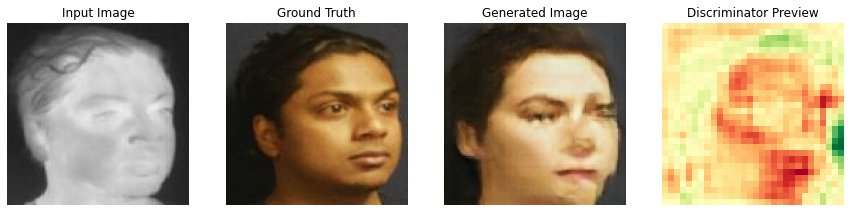

In [148]:
example_input, example_target = next(iter(test_dataset.take(1)))
generate_images(generator, example_input, example_target)

# Training

In [33]:
def progress_bar(x, total, length):
    filled = int((x / total) * length)
    not_filled = length - filled
    return '[' + '='*filled + '.'*not_filled + ']' + f' {x}/{total}'

In [34]:
log_dir = "logs/"
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

In [35]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                        generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                            discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [36]:
UPDATE_INTERVAL = 20
CHECKPOINT_INTERVAL = 10000

def fit(train_ds, test_ds, steps, example_input, example_target):

    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():

        train_step(input_image, target, step)

        # Update visualisation
        if step % UPDATE_INTERVAL == 0:
            display.clear_output(wait=True)
            print(progress_bar(int(step), steps, 80))
            # print(f'Step: {step:05d}/{steps}')
            avg_time = (time.time() - start)/UPDATE_INTERVAL
            eta = int(steps-step) * avg_time
            print(f'Avg. time: {avg_time:.2f} sec/step')
            print(f'ETA: {eta/60.0:.2f} min')
            start = time.time()
            generate_images(generator, example_input, example_target)
    
        # Save (checkpoint) the model every 5k steps
        if step % CHECKPOINT_INTERVAL == 0 and step != 0:
            print('Saving checkpoint...')
            checkpoint.save(file_prefix=str(CHECKPOINT_DIR / f'ckpt-step={step:06d}'))

In [37]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

[===============================================================================.] 39980/40000
Avg. time: 0.17 sec/step
ETA: 0.06 min


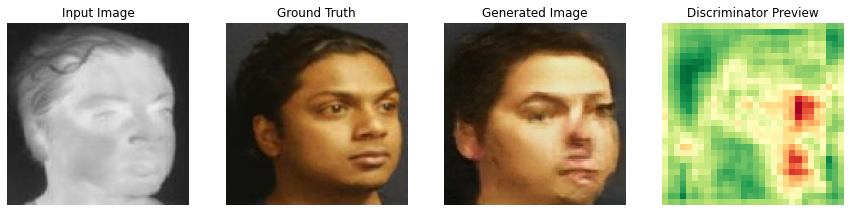

In [42]:
fit(train_dataset, test_dataset, steps=40000, example_input=example_input, example_target=example_target)

# Load last checkpoint and test

In [43]:
!ls {checkpoint_dir}

checkpoint		     ckpt-36.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-36.index
ckpt-10.index		     ckpt-37.data-00000-of-00001
ckpt-11.data-00000-of-00001  ckpt-37.index
ckpt-11.index		     ckpt-38.data-00000-of-00001
ckpt-12.data-00000-of-00001  ckpt-38.index
ckpt-12.index		     ckpt-39.data-00000-of-00001
ckpt-13.data-00000-of-00001  ckpt-39.index
ckpt-13.index		     ckpt-3.data-00000-of-00001
ckpt-14.data-00000-of-00001  ckpt-3.index
ckpt-14.index		     ckpt-40.data-00000-of-00001
ckpt-15.data-00000-of-00001  ckpt-40.index
ckpt-15.index		     ckpt-41.data-00000-of-00001
ckpt-16.data-00000-of-00001  ckpt-41.index
ckpt-16.index		     ckpt-42.data-00000-of-00001
ckpt-17.data-00000-of-00001  ckpt-42.index
ckpt-17.index		     ckpt-43.data-00000-of-00001
ckpt-18.data-00000-of-00001  ckpt-43.index
ckpt-18.index		     ckpt-44.data-00000-of-00001
ckpt-19.data-00000-of-00001  ckpt-44.index
ckpt-19.index		     ckpt-45.data-00000-of-00001
ckpt-20.data-00000-of-00001  ckpt-45.index
ckpt

In [113]:
print(tf.train.latest_checkpoint(checkpoint_dir))

./training_checkpoints/ckpt-54


In [44]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

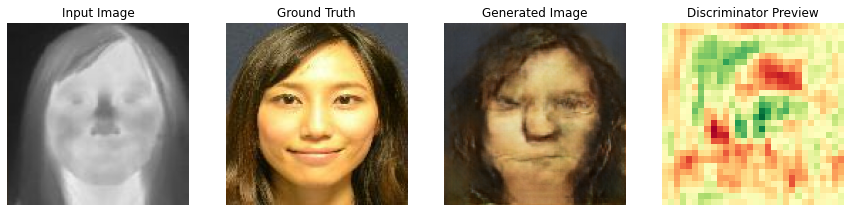

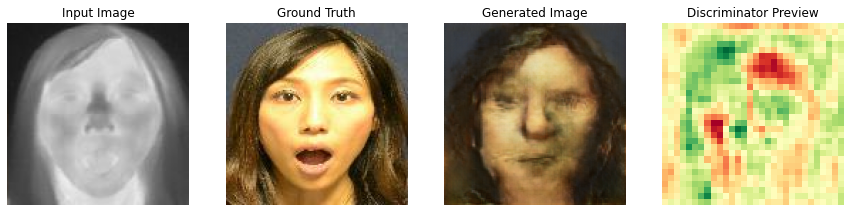

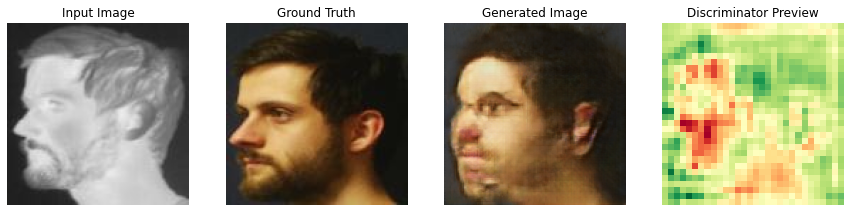

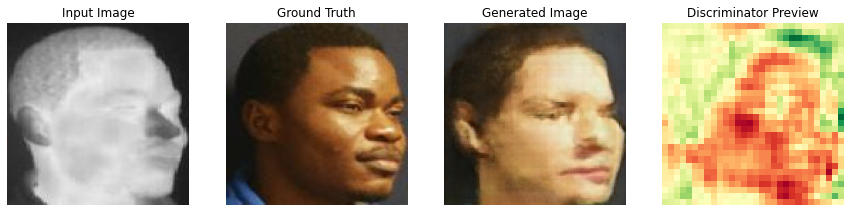

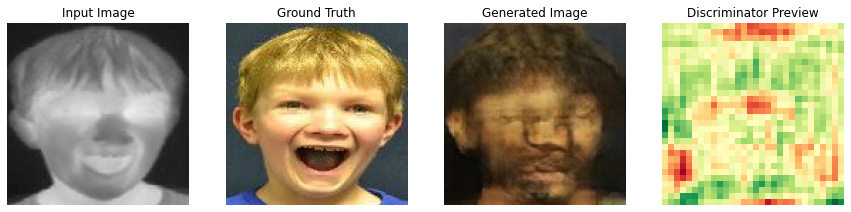

In [152]:
VAL_PATH = BASE_PATH / 'data/tufts_face_rgb_ir_v2_stitched/test'

val_dataset = tf.data.Dataset.list_files(str(VAL_PATH / '*.jpg'))
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(BATCH_SIZE)

for inp, tar in val_dataset.take(5):
    generate_images(generator, inp, tar)

In [119]:
VAL_PATH = BASE_PATH / 'data/tufts_face_rgb_ir_v2_stitched/test'
GEN_PATH = BASE_PATH / 'results/pix2pix_tufts_attn_v1/test_generated'

for path in tqdm(VAL_PATH.glob('*.jpg')):
    b, a = load_image_test(str(path))
    gen_image = generator(tf.expand_dims(b, 0), training=False)[0]
    tf.keras.preprocessing.image.save_img(str(GEN_PATH / path.name), gen_image)

139it [00:03, 35.44it/s]
